In [1]:
%matplotlib inline

In [291]:
import numpy as np
import matplotlib.pyplot as pl
from pylab import rcParams
rcParams['figure.figsize'] =  14,10
import matplotlib
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['text.latex.unicode'] = False
import scipy.signal

In [382]:
def generate_system(M_f=4,h_type=0):
    fB = 32e9;	# Velocidad de simbolos (baud rate)
    T = 1/fB; # Tiempo entre simbolos
    M = M_f;  #Factor de sobremuestreo
    fs = fB*M;	# Sample rate
    Ts=1./fs
    Tc=Ts/(64/M)
    beta = .123#; %Factor de roll-off
    beta_h=0.1
    L = 20;  # 2*L*M+1 es el largo del filtro sobremuestreado
    L_r = 1024*14 #Largo del filtro reconstructor
    t = np.arange(-L,L,1./M)*T#[-L:1/M:L]*T;
    t_r=np.arange(-L_r*Tc,L_r*Tc,Tc)
    n_delay_filter = L*M# %Retardo del filtro
    def gen_filter():
        return [np.sinc(t2/T)*np.cos(np.pi*beta*t2/T)/(1-4*beta**2*t2**2/T**2) for t2 in t];
    def gen_h_filter():
        return [np.sinc(t2/Ts)*(1+0*np.cos(np.pi*beta_h*t2/Ts)/(1-4*beta_h**2*t2**2/Ts**2)) for t2 in t_r];
    def gen_pulse():
        return [1]*(64/M)
    def gen_pulse_and_butter():
        b,a=scipy.signal.butter(3,0.1)
        imp=scipy.signal.lfilter(a=a,b=b,x=[0]*127+[1]+[0]*127)
        return np.convolve(imp,gen_pulse())
    
    ht_type=[gen_h_filter(),gen_pulse(),gen_pulse_and_butter()]
    gn=gen_filter()
    ht=ht_type[h_type]
    return gn,ht,Tc,Ts,t,t_r

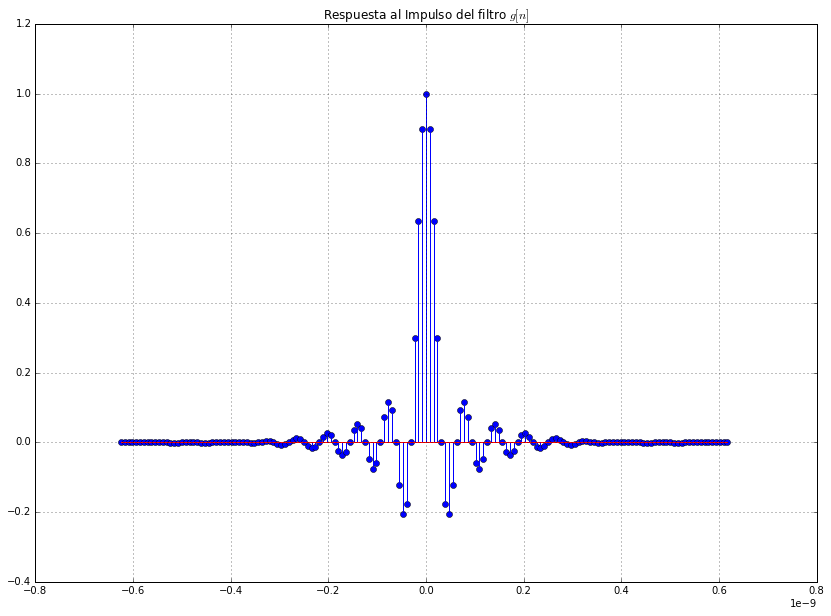

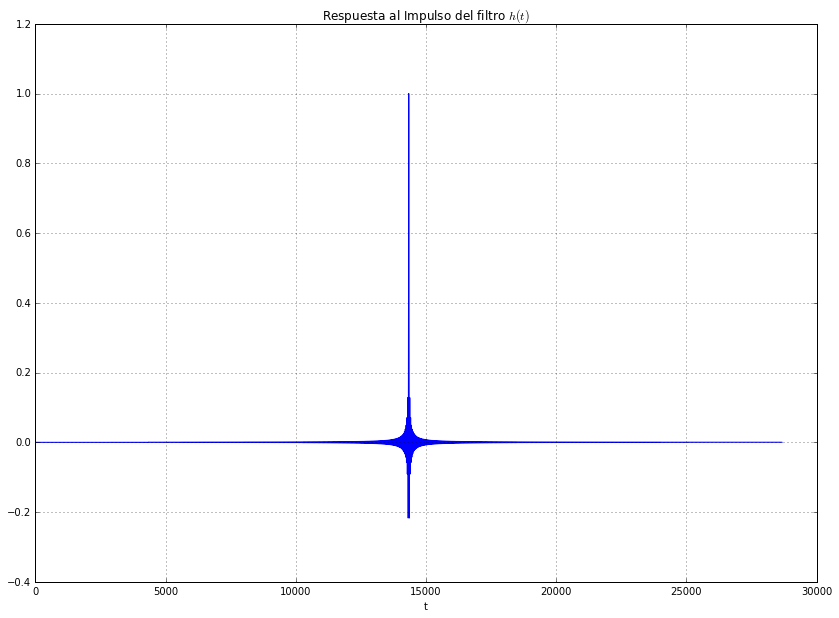

In [383]:
#pl.figure(figsize=(14,10))
gn,ht,Tc,Ts,t,t_r=generate_system(h_type=0)
pl.title('Respuesta al Impulso del filtro $g[n]$');
pl.stem(t,gn)
pl.grid(True)


pl.figure()
pl.plot(ht)
pl.title('Respuesta al Impulso del filtro $h(t)$');
pl.xlabel('t');
pl.grid(True)
pl.draw()


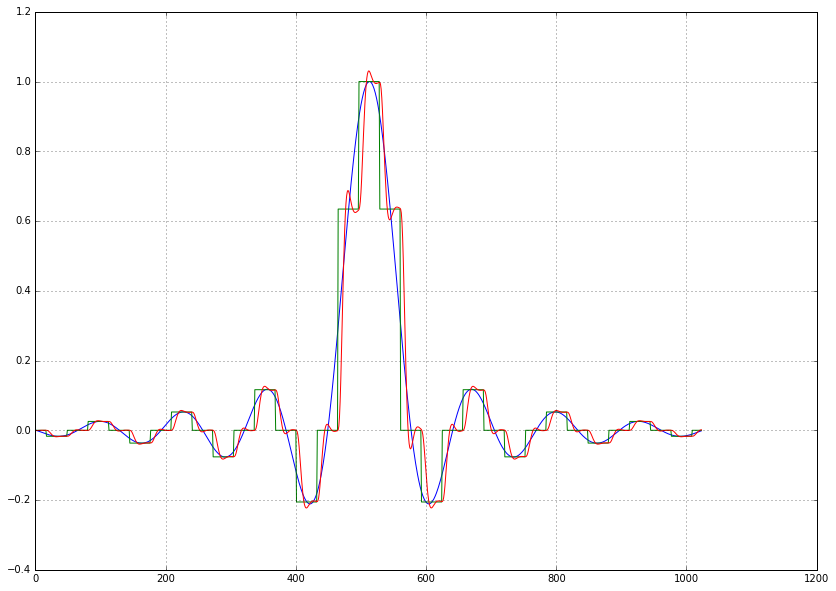

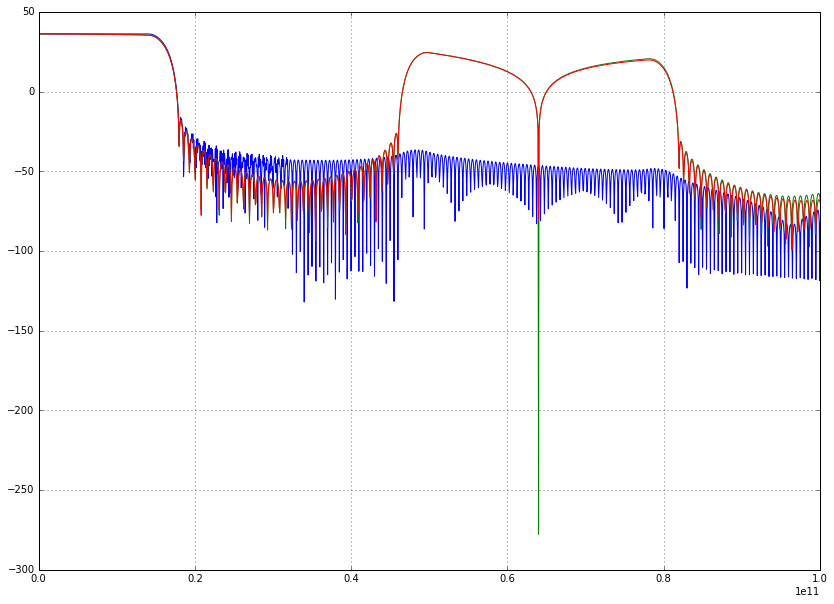

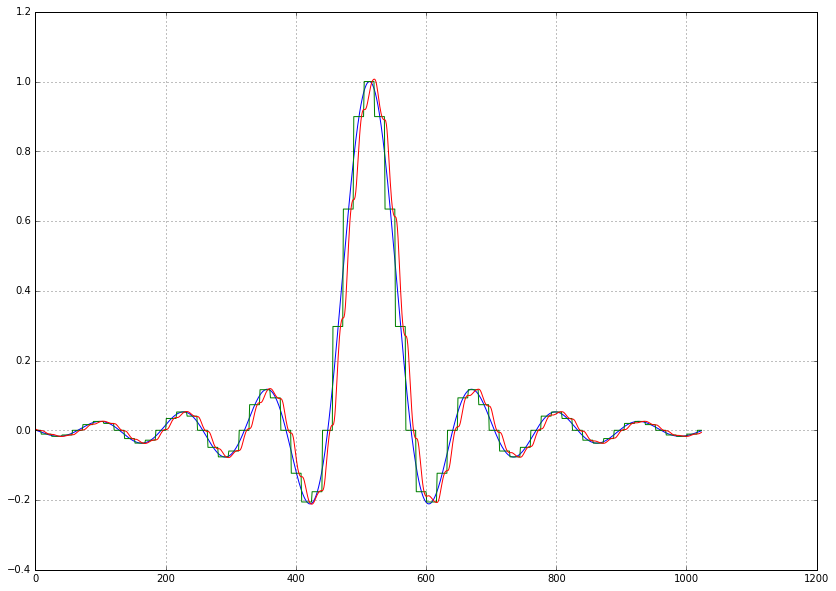

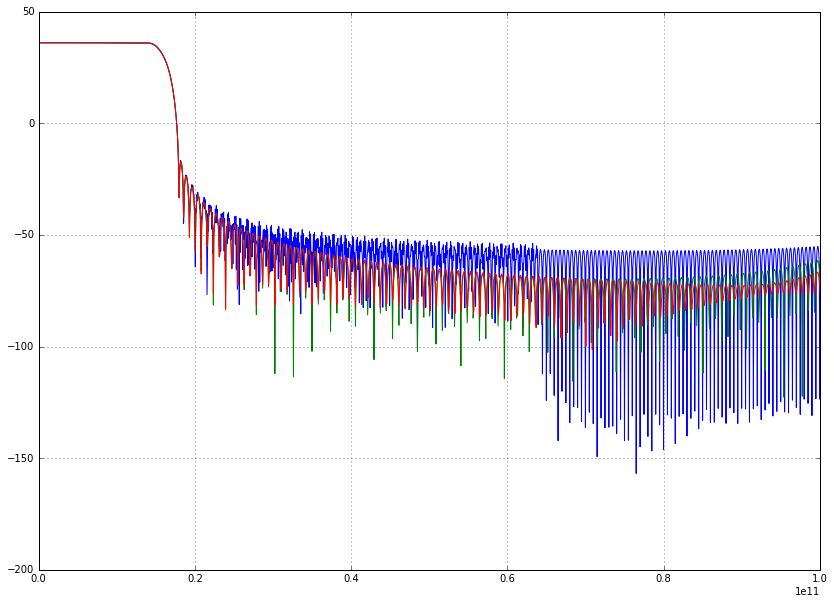

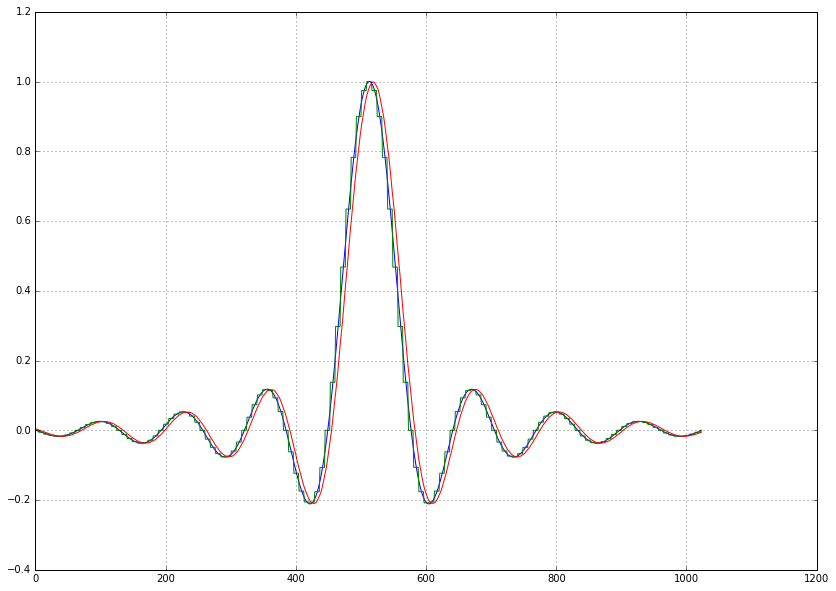

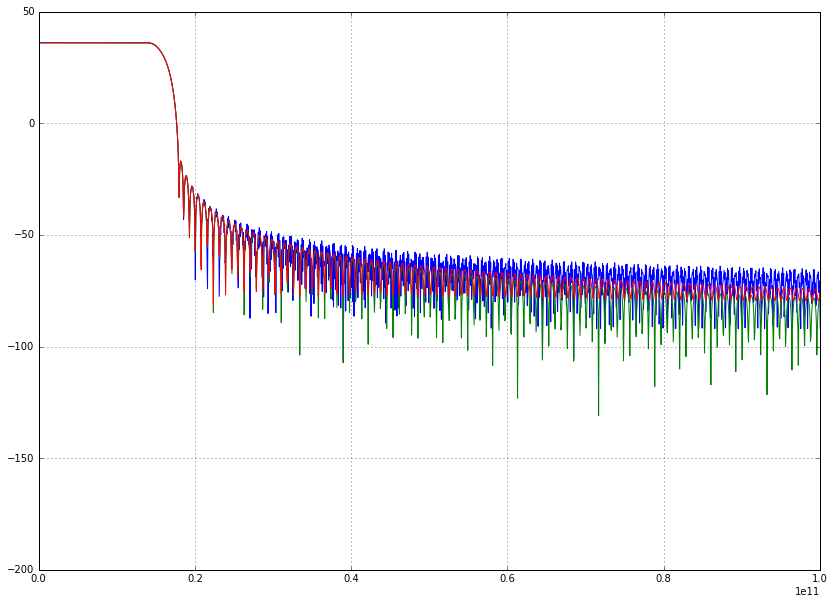

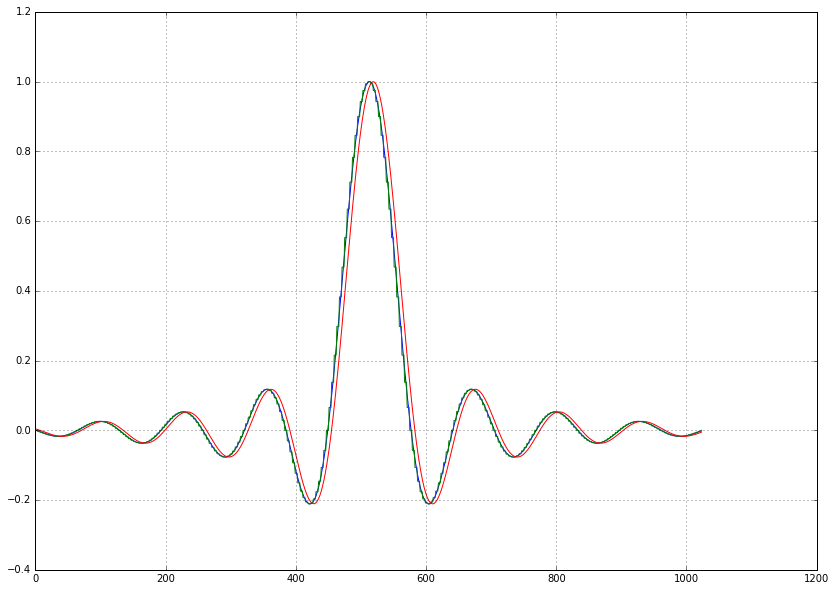

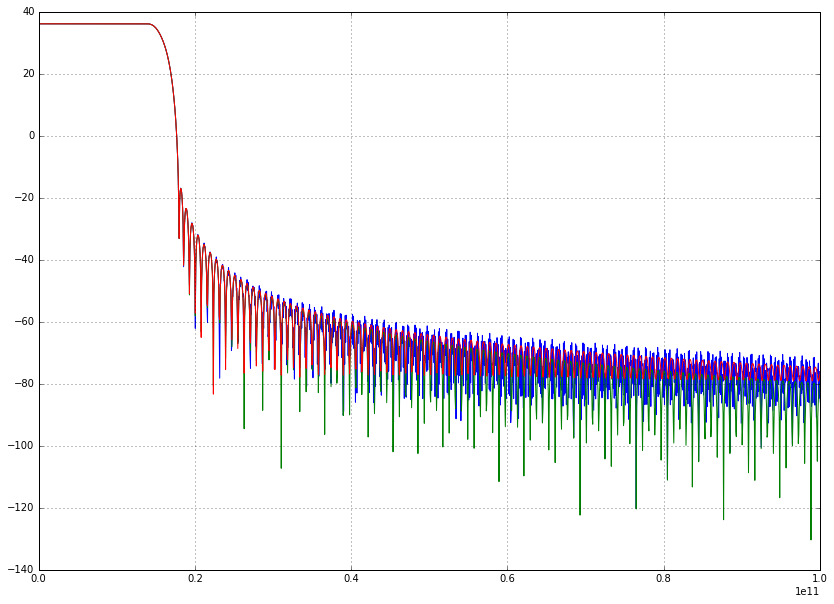

In [384]:

for k in range(3):
    for i in [2,4,8,16]:
        gn,ht,Tc,Ts,t,t_r=generate_system(M_f=i,h_type=k)
        gt=[]
        for j in xrange(len(gn)):
            gt.append(gn[j])
            gt.extend(list(np.zeros(64/i-1)))

        pl.figure(i+1)
        htt=np.convolve(ht,gt,mode='same')
        
        pl.plot(htt[len(htt)/2-512:len(htt)/2+512])
        pl.grid(True)


        pl.draw()
        pl.figure(i+2)
        from scipy import signal
        w,Htw=signal.freqz(htt,worN=2048*8)
        #Htw,w=pl.psd(htt,Fs=1/Tc,scale_by_freq=False)
        pl.xlim([0,1e11])
        #pl.figure(3)
        pl.plot(1/(Tc*2*np.pi)*w[:2048],20*np.log10(abs(Htw[:2048])))
        #pl.psd(htt,Fs=1/Tc)
        pl.hold(True)
        pl.grid(True)
        pl.draw()

In [146]:
def sweep_omega():
    Omega = np.arange(0,1,1./2**8)*np.pi;
    N = 1000;
    H_Mag=[]                  
    H_Fase=[]
    for omega in Omega:
        xn = [np.exp(np.complex(0,omega*n)) for n in xrange(N)];
        yn = np.convolve(xn,gn);
        H_Mag.append( np.abs(yn[N/2]))
        H_Fase.append(np.angle(yn[N/2]*np.conj(xn[N/2-n_delay_filter])))
    return Omega,H_Mag,H_Fase
Omega,H_Mag,H_Fase=sweep_omega()
from scipy import signal
w,h=signal.freqz(ht,whole=True)

In [151]:
def sweep_omega_and_reconstruct():
    Omega = np.arange(0,1,1./2**8)*np.pi;
    N = 1000;
    H_Mag=[]                  
    H_Fase=[]
    for omega in Omega:
        xn = [np.exp(np.complex(0,omega*n)) for n in xrange(N)];
        yn = np.convolve(xn,gn);
        ys = 
        H_Mag.append( np.abs(yn[N/2]))
        H_Fase.append(np.angle(yn[N/2]*np.conj(xn[N/2-n_delay_filter])))
    return Omega,H_Mag,H_Fase
Omega,H_Mag,H_Fase=sweep_omega()
from scipy import signal
w,h=signal.freqz(ht,whole=True)

SyntaxError: invalid syntax (<ipython-input-151-e84dd9f947ac>, line 9)

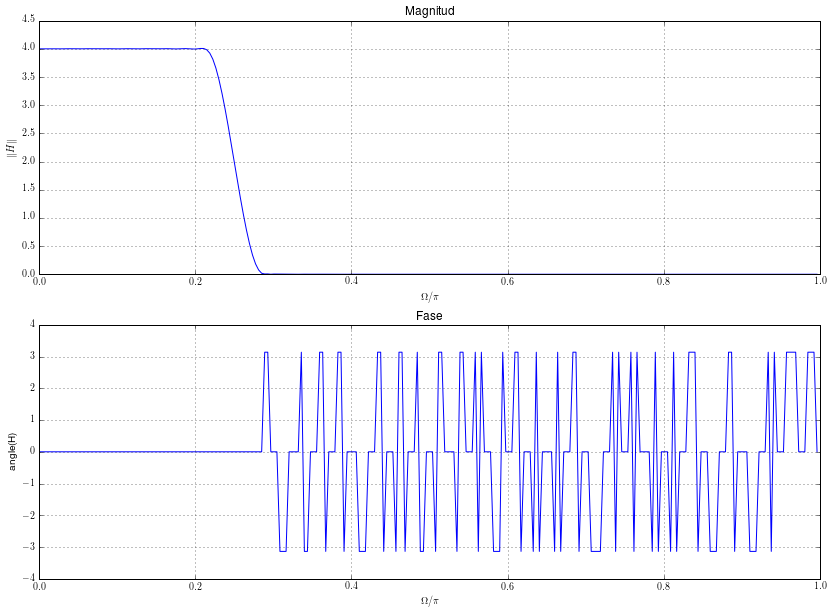

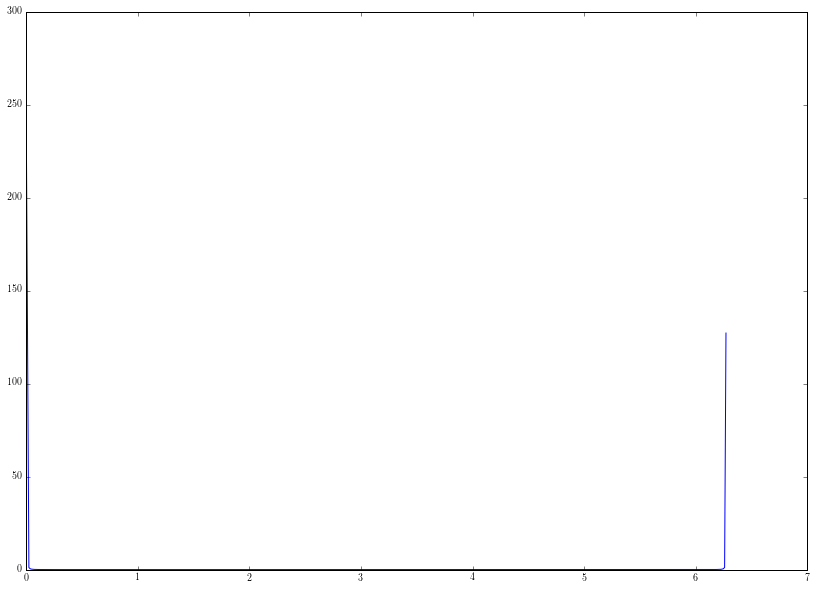

In [60]:
def plot_omega():
    pl.subplot(2,1,1)
    pl.plot(Omega/np.pi,H_Mag);
    pl.title('Magnitud');
    pl.ylabel('$\|H\|$')
    pl.xlabel('$\Omega/\pi$');
    pl.grid()
    pl.subplot(2,1,2) 
    pl.plot(Omega/np.pi,H_Fase);
    pl.title('Fase');
    pl.ylabel('angle(H)')
    pl.xlabel('$\Omega/\pi$');
    pl.grid(True)
    pl.draw()
plot_omega()
pl.figure()
pl.plot(w, abs(h), 'b')
pl.draw()

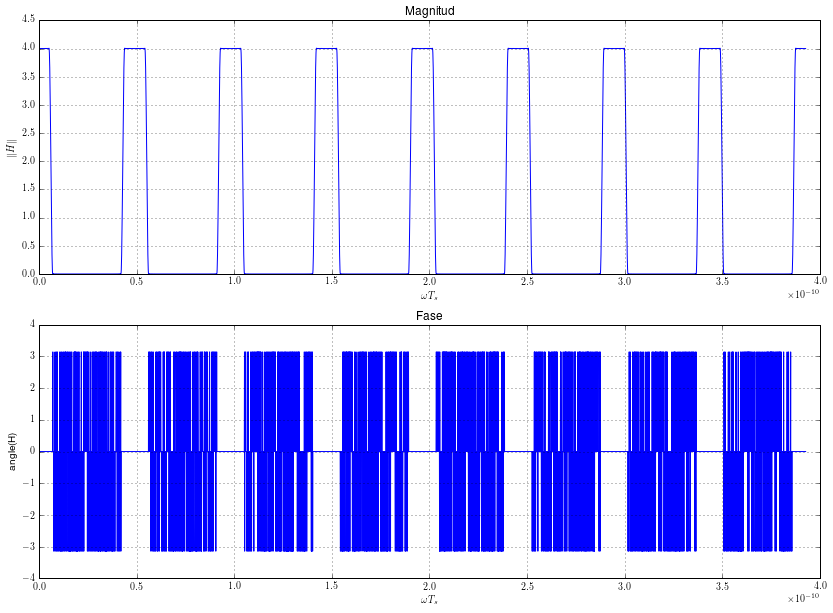

In [31]:
def plot_omega_ts():
    pl.subplot(2,1,1)
    pl.plot(omega_ts,H_Mag);
    pl.title('Magnitud');
    pl.ylabel('$\|H\|$')
    pl.xlabel('$\omega T_s$');
    pl.grid()
    pl.subplot(2,1,2) 
    pl.plot(omega_ts,H_Fase);
    pl.title('Fase');
    pl.ylabel('angle(H)')
    pl.xlabel('$\omega T_s$');
    pl.grid(True)
    pl.draw()
plot_omega_ts()

In [13]:
n_symbols = 1000;
ak = 2*np.random.randint(2,size=(1,n_symbols))-1
xn=np.zeros((n_symbols*M))
xn[::M]=ak

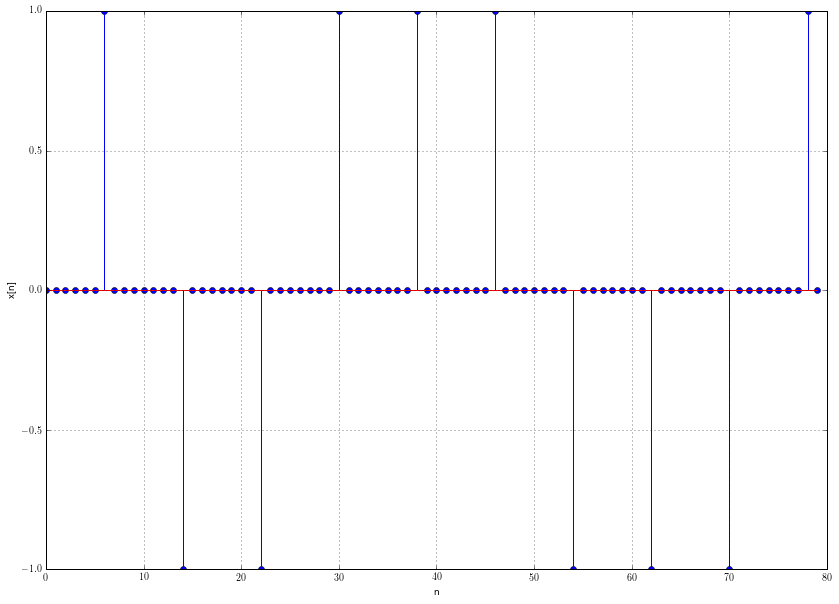

In [14]:
pl.stem(xn[10:10+M*10])

pl.ylabel('x[n]')
pl.xlabel('n');
pl.grid(True)
pl.draw()

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in cdouble_scalars


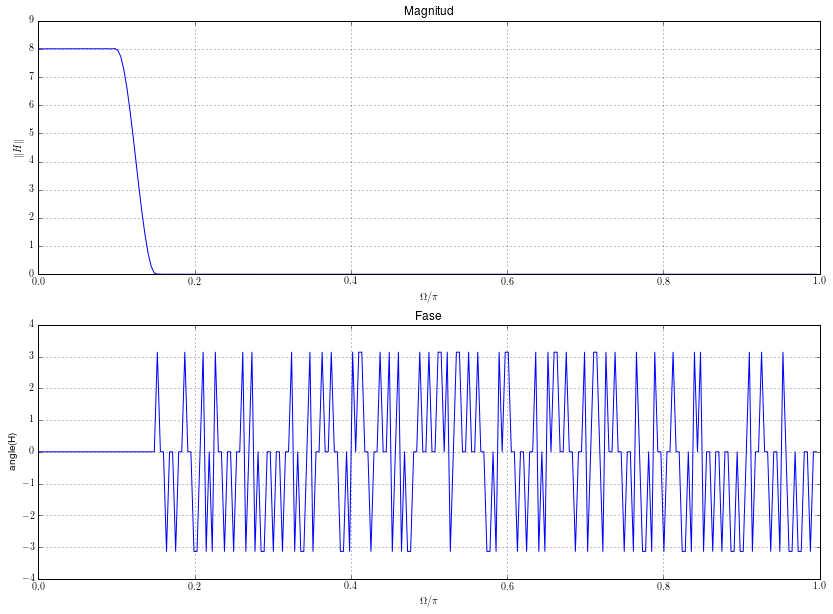

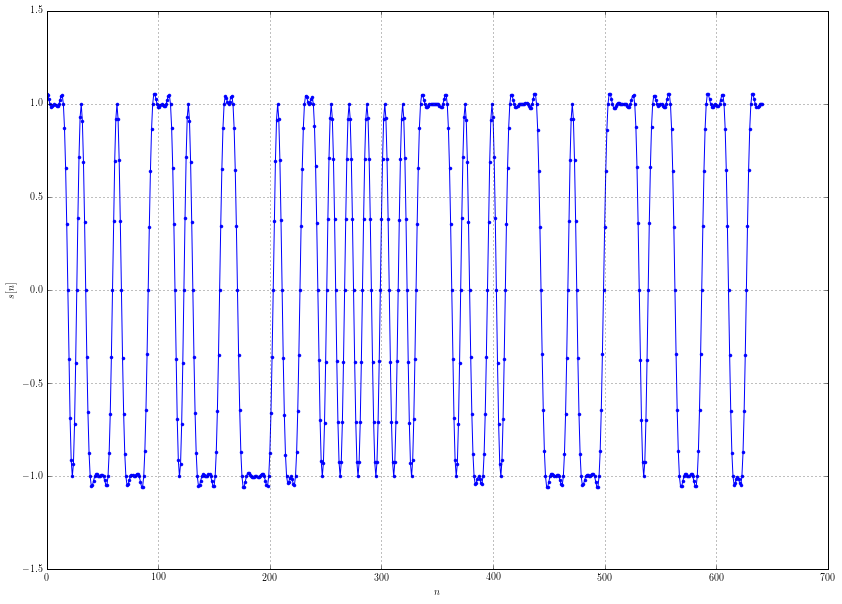

In [20]:
def sn_convolve():
    return np.convolve(xn,gn);
    
def plot_time(sn):
    pl.figure()
    pl.plot(sn[(2*L*M+1):(2*L*M+1)*3],'.-');
    pl.ylabel('$s[n]$')
    pl.xlabel('$n$');
    pl.grid(True)

beta=0.999
sweep_omega()
plot_omega()
gn=gen_filter()
sn=sn_convolve()
plot_time(sn)
pl.draw()

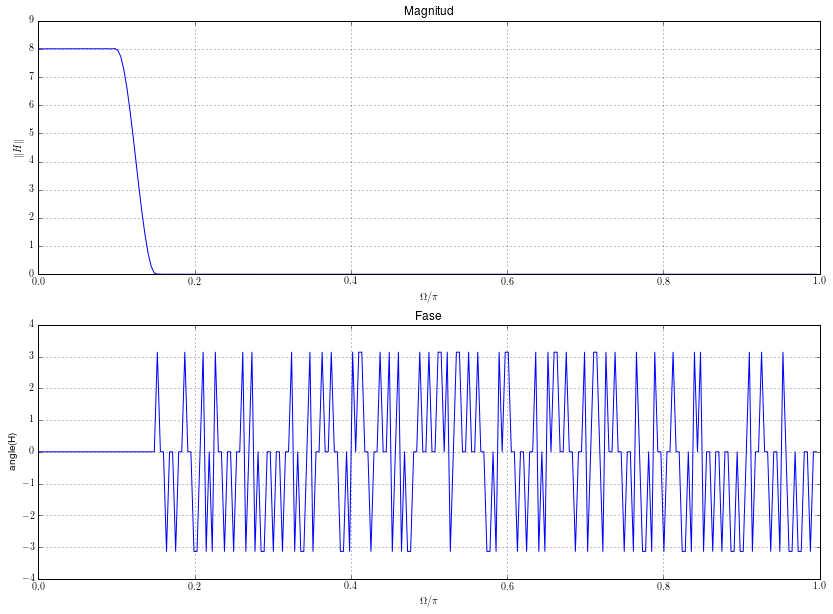

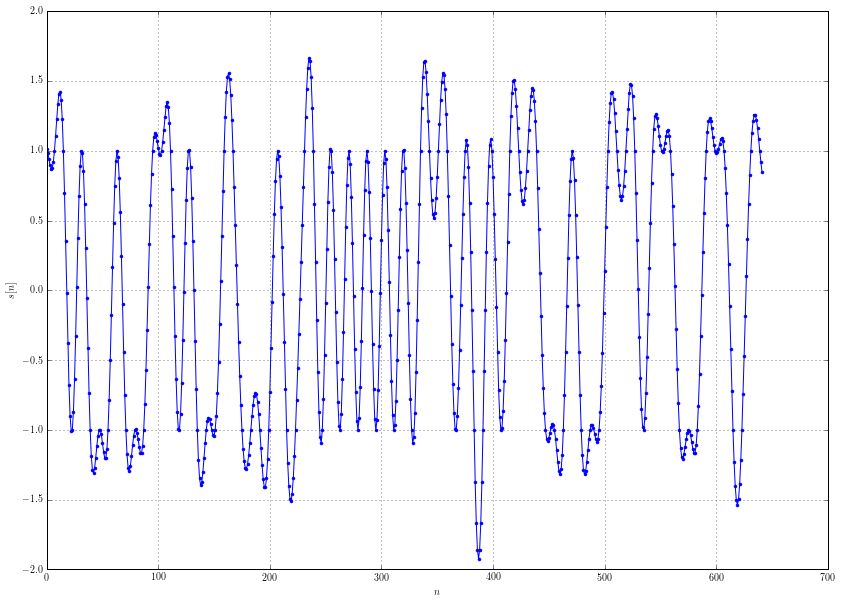

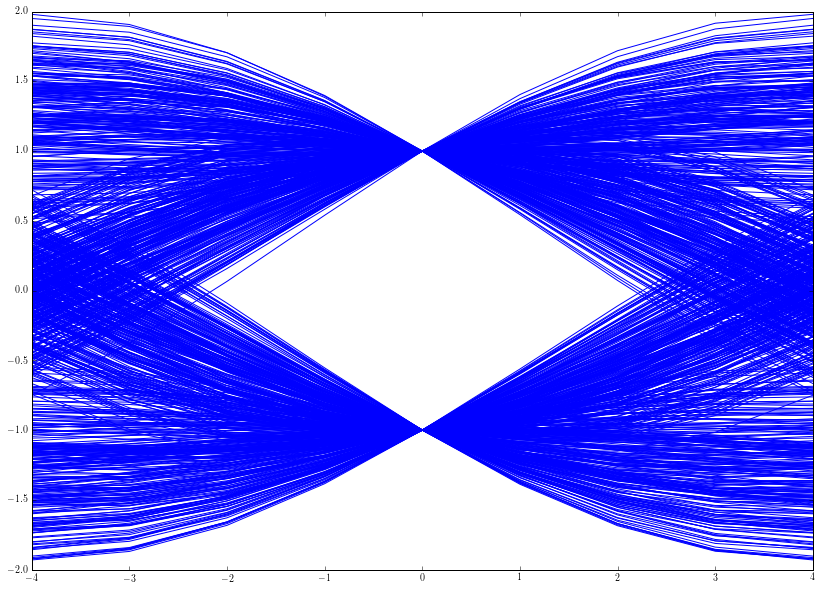

In [17]:
def plot_eye(sn):
    pl.figure()
    d = 5; #Delay para centrar el ojo
    pl.hold(True)
    for m in range( 2*L,n_symbols-(2*L+1)):
        sn_p = sn[m*M+d-1:m*M+d+M];
        pl.plot(range(-M/2,M/2+1),sn_p,'b')
beta=0.205
gn=gen_filter()
sn=sn_convolve()
Omega,H_Mag,H_Fase=sweep_omega()
plot_omega()
plot_time(sn)
plot_eye(sn)
pl.draw()

In [18]:
np.pi/8

0.39269908169872414